In [1]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az
import pytensor.tensor as tt

rng = np.random.default_rng(1331)

In [2]:
demo_df = pd.read_csv(r"data/demographics.csv")
demo_df.columns = ["Gender", "Age", "Weekly Game Time", "Platforms"]

# Demographics

/tmp/ipykernel_6119/2175280347.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), size = 20)
/tmp/ipykernel_6119/2175280347.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(a.get_yticklabels(), size = 20)
/tmp/ipykernel_6119/2175280347.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_yticklabels(b.get_yticklabels(), size = 20)
/tmp/ipykernel_6119/2175280347.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), size = 20)
/tmp/ipykernel_6119/2175280347.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

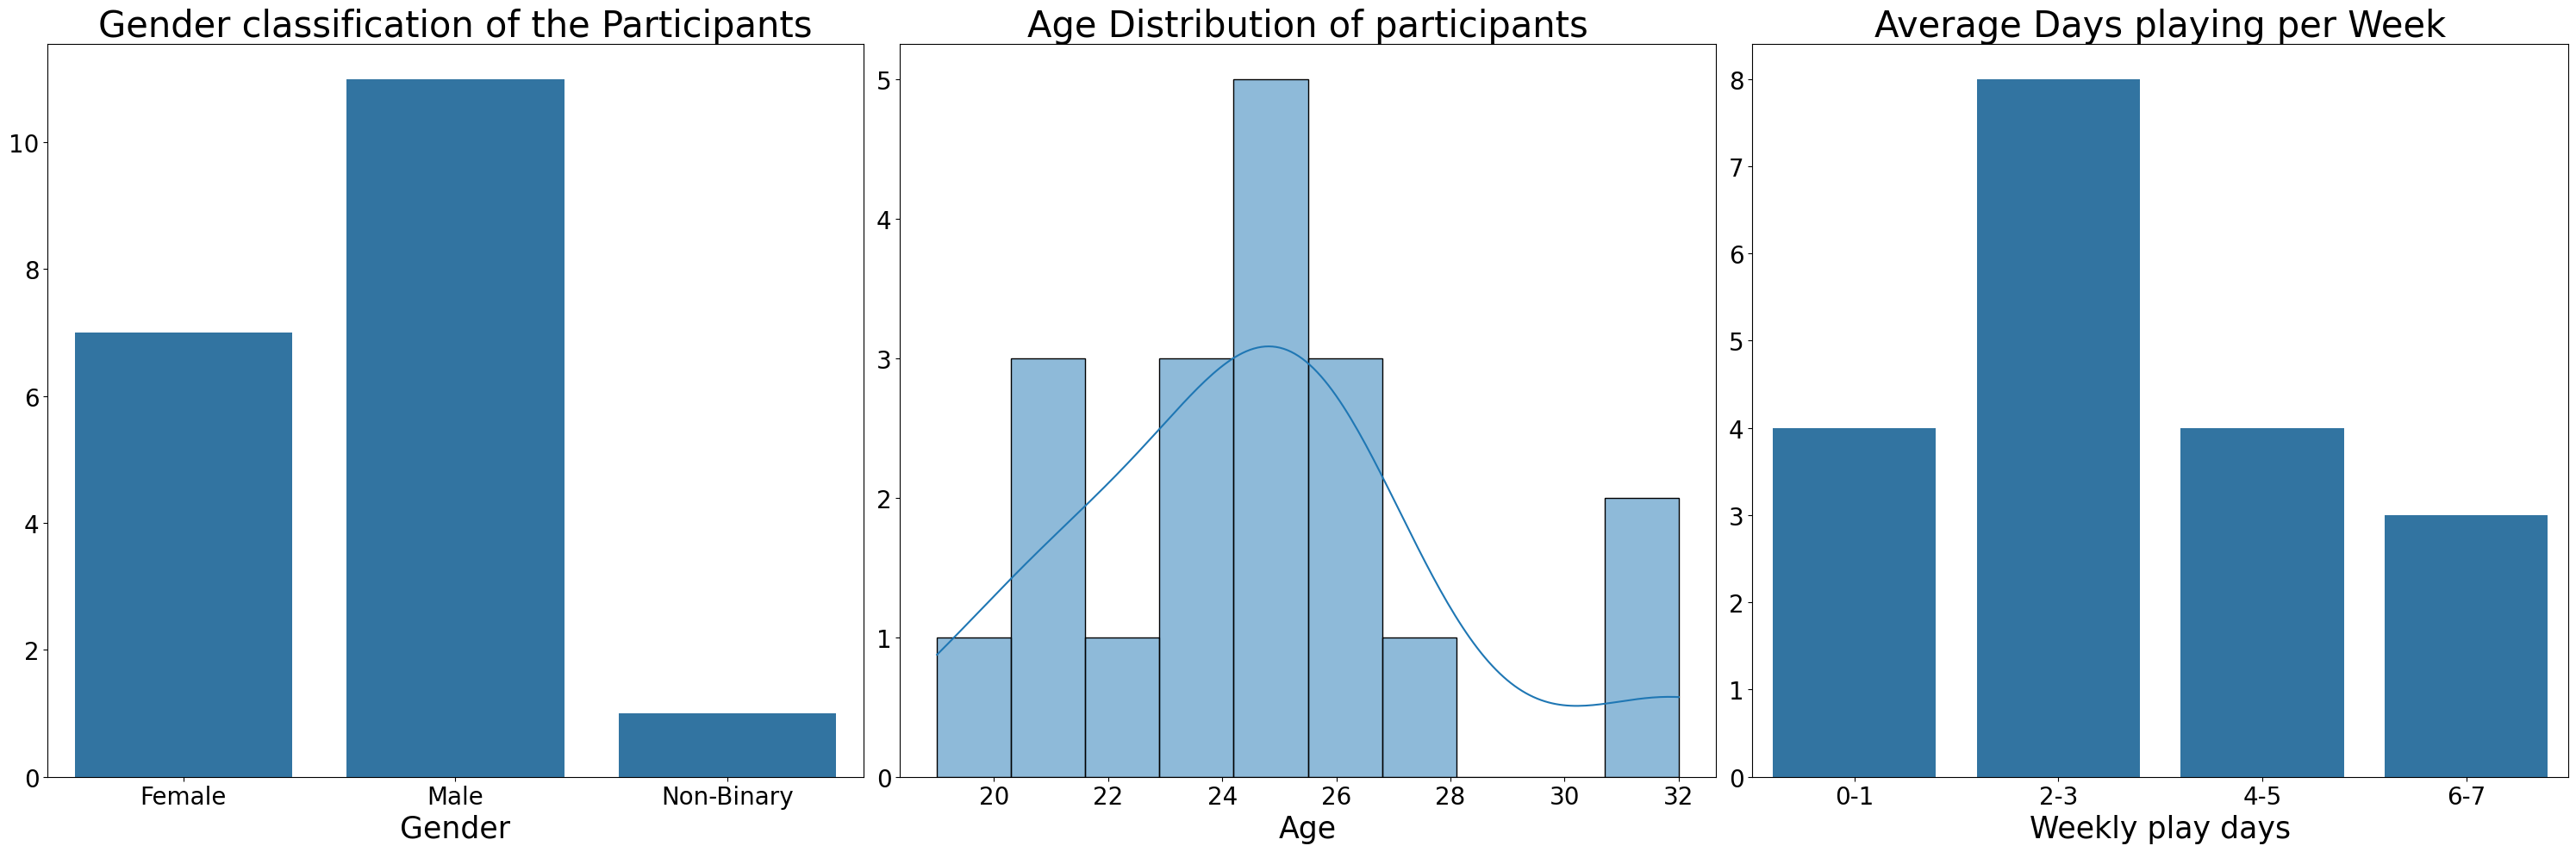

In [3]:
fig, axs = plt.subplots(1,3, figsize=(30,10))

a = sns.countplot(demo_df, x="Gender", ax=axs[0])
a.set_title("Gender classification of the Participants", fontsize=30)
a.set_xlabel("Gender", fontsize=25)
a.set_ylabel("", fontsize=25)
a.set_xticklabels(a.get_xticklabels(), size = 20)
a.set_yticklabels(a.get_yticklabels(), size = 20)
b = sns.histplot(demo_df, x="Age", ax=axs[1], kde=True, bins=10)
b.set_title("Age Distribution of participants", fontsize=30)
b.set_yticklabels(b.get_yticklabels(), size = 20)
b.set_xticklabels(b.get_xticklabels(), size = 20)
b.set_xlabel("Age", fontsize=25)
b.set_ylabel("", fontsize=25)
c = sns.countplot(demo_df.sort_values("Weekly Game Time"), x="Weekly Game Time", ax=axs[2])
c.set_title("Average Days playing per Week", fontsize=30)
c.set_xlabel("Weekly play days", fontsize=25)
c.set_xticklabels(c.get_xticklabels(), size = 20)
c.set_yticklabels(c.get_yticklabels(), size = 20)
c.set_ylabel("", fontsize=25)
# plt.suptitle("Demographic information of Participants", fontsize=50)
plt.tight_layout()

In [4]:
pxi_df = pd.read_csv(r"data/pxi_results.csv")

pxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  163 non-null    object 
 1   game_name       163 non-null    object 
 2   trial           163 non-null    float64
 3   mode            163 non-null    float64
 4   difficulty      163 non-null    float64
 5   pxi_AA          162 non-null    object 
 6   pxi_CH          163 non-null    object 
 7   pxi_EC          163 non-null    object 
 8   pxi_GR          163 non-null    object 
 9   pxi_PF          163 non-null    object 
 10  pxi_AUT         162 non-null    object 
 11  pxi_CUR         163 non-null    object 
 12  pxi_IMM         162 non-null    object 
 13  pxi_MAS         162 non-null    object 
 14  pxi_MEA         163 non-null    object 
 15  pxi_ENJ         163 non-null    object 
 16  STIMES          163 non-null    float64
 17  TIMES           163 non-null    flo

In [5]:
logs_df = pd.read_csv(r"data/atari_logs.csv").drop("Unnamed: 0", axis=1)

logs_df.head()

,participant_id,game_name,trial,mode,difficulty,frame,action,ram_0,ram_1,ram_2,...,ram_118,ram_119,ram_120,ram_121,ram_122,ram_123,ram_124,ram_125,ram_126,ram_127
0,P004,WordZapper-v5,1,2,3,0,0,182,253,113,...,0,0,0,0,0,0,163,25,190,245
1,P004,WordZapper-v5,1,2,3,1,0,182,253,113,...,0,0,0,0,0,0,163,25,190,245
2,P004,WordZapper-v5,1,2,3,2,0,182,253,113,...,0,0,0,0,0,0,163,25,190,245
3,P004,WordZapper-v5,1,2,3,3,0,182,253,113,...,0,0,0,0,0,0,163,25,190,245
4,P004,WordZapper-v5,1,2,3,4,0,182,253,113,...,0,0,0,0,0,0,163,25,190,245


In [14]:
import causalgraphicalmodels

ImportError: cannot import name 'Iterable' from 'collections' (/home/thejarmanitor/miniconda3/lib/python3.10/collections/__init__.py)

# Boxing

In [6]:
pxi_df_box = pxi_df[pxi_df["game_name"] == "Boxing"].drop(columns="game_name")

final_frames = logs_df[logs_df["game_name"]=="Boxing-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_box_df = logs_df.iloc[list(final_frames.values)]

box_score = grouped_box_df[["participant_id", "trial", "ram_18", "ram_19"]]
box_final = pd.merge(pxi_df_box, box_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial")).dropna()
box_final.head()


,participant_id,trial,mode,difficulty,pxi_AA,pxi_CH,pxi_EC,pxi_GR,pxi_PF,pxi_AUT,pxi_CUR,pxi_IMM,pxi_MAS,pxi_MEA,pxi_ENJ,STIMES,TIMES,ram_18,ram_19
0,P009,3.0,0.0,0.0,Agree,Strongly Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,1.746089e+12,1.746090e+12,119,72
2,P015,3.0,0.0,0.0,Neutral,Agree,Agree,Strongly Agree,Slightly agree,slightly disagree,Neutral,Strongly Agree,slightly disagree,slightly disagree,Neutral,1.746528e+12,1.746528e+12,32,56
3,P011,3.0,0.0,3.0,Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Slightly agree,Agree,Strongly Agree,Agree,Strongly Agree,Strongly Agree,1.746111e+12,1.746111e+12,89,40
4,P003,2.0,0.0,0.0,Strongly Agree,Slightly agree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Agree,Strongly Agree,Agree,Agree,Strongly Agree,1.745572e+12,1.745572e+12,36,49
5,P013,1.0,0.0,2.0,Neutral,Agree,Agree,Strongly Agree,Strongly Agree,Neutral,Neutral,Agree,Neutral,slightly disagree,Slightly agree,1.746434e+12,1.746434e+12,18,18


In [7]:
pxi_id_to_number = {
    "strongly disagree": 0,
    "disagree": 1,
    "slightly disagree":2,
    "neutral": 3,
    "slightly agree": 4,
    "agree": 5,
    "strongly agree": 6
}

diff_order = {
    2:0,
    3:1,
    0:2,
    1:3
}

diff_id,   diff_cats  = pd.factorize(box_final["difficulty"].replace(diff_order), sort=True)
trial_id, trial_cats  = pd.factorize(box_final["trial"], sort=True)
ch_codes, ch_levels   = pd.factorize(box_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
mas_codes, mas_levels = pd.factorize(box_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
imm_codes, imm_levels = pd.factorize(box_final["pxi_IMM"].str.lower().replace(pxi_id_to_number), sort=True)
scores                = box_final["ram_18"].values
enemy_scores          = box_final["ram_19"].values

/tmp/ipykernel_6119/4021566141.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ch_codes, ch_levels   = pd.factorize(box_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_6119/4021566141.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mas_codes, mas_levels = pd.factorize(box_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_6119/4021566141.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain t

In [8]:
imm_levels

Index([4, 5, 6], dtype='int64')

/tmp/ipykernel_6119/1237145508.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  a = sns.boxplot(box_final[["pxi_CH", "pxi_IMM", "pxi_MAS"]].apply(lambda x: x.str.lower().replace(pxi_id_to_number)), notch=True,ax=ax)
/tmp/ipykernel_6119/1237145508.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(range(-4,4,1), fontsize=12)
/tmp/ipykernel_6119/1237145508.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(["Challenge", "Immersion", "Mastery"], fontsize=12)


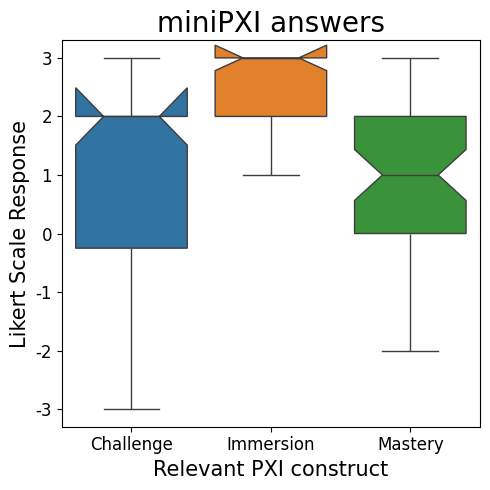

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

a = sns.boxplot(box_final[["pxi_CH", "pxi_IMM", "pxi_MAS"]].apply(lambda x: x.str.lower().replace(pxi_id_to_number)), notch=True,ax=ax)
a.set_title("miniPXI answers", fontsize=20)
a.set_yticklabels(range(-4,4,1), fontsize=12)
a.set_xticklabels(["Challenge", "Immersion", "Mastery"], fontsize=12)
a.set_ylabel("Likert Scale Response", fontsize=15)
a.set_xlabel("Relevant PXI construct", fontsize=15)


plt.tight_layout()

/tmp/ipykernel_6119/1386274955.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  a = sns.boxplot(x=box_final["difficulty"].replace(diff_order), y=box_final[variable[i]].str.lower().replace(pxi_id_to_number), ax=ax[i])
/tmp/ipykernel_6119/1386274955.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(range(-4,4,1), fontsize=12)
/tmp/ipykernel_6119/1386274955.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  a = sns.boxplot(x=b

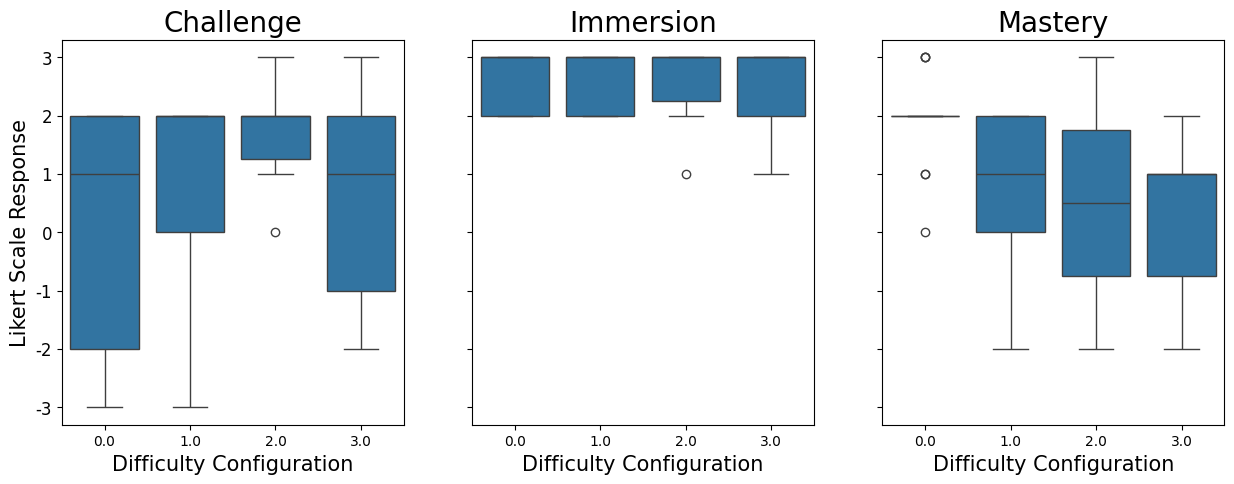

In [10]:
fig, ax = plt.subplots(1,3, figsize=(15,5),sharey=True, sharex=True)

variable = ["pxi_CH", "pxi_IMM", "pxi_MAS"]

label = ["Challenge", "Immersion", "Mastery"]

for i in range(3):
    a = sns.boxplot(x=box_final["difficulty"].replace(diff_order), y=box_final[variable[i]].str.lower().replace(pxi_id_to_number), ax=ax[i])
    a.set_title(label[i], fontsize=20)
    a.set_yticklabels(range(-4,4,1), fontsize=12)
    a.set_ylabel("Likert Scale Response", fontsize=15)
    a.set_xlabel("Difficulty Configuration", fontsize=15)
    
    # b = sns.boxplot(x=box_final["trial"], y=box_final[variable[i]].str.lower().replace(pxi_id_to_number), ax=ax[1,i])
    # b.set_title(label[i], fontsize=20)
    # b.set_yticklabels(range(-4,4,1), fontsize=12)
    # b.set_ylabel("Likert Scale Response", fontsize=15)
    # b.set_xlabel("Trial", fontsize=15)

/tmp/ipykernel_6119/4268617538.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=12)
/tmp/ipykernel_6119/4268617538.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_yticklabels(b.get_yticklabels(), fontsize=12)


Text(0.5, 0, 'Score')

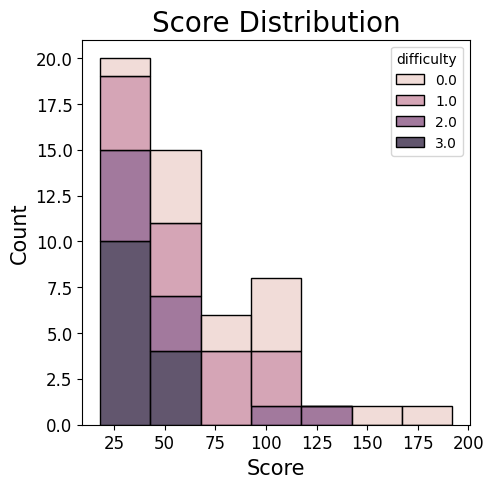

In [11]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
b = sns.histplot(x=box_final["ram_18"], hue=box_final["difficulty"].replace(diff_order),ax=ax, multiple="stack",common_norm=False)
b.set_title("Score Distribution", fontsize=20)
b.set_xticklabels(b.get_xticklabels(), fontsize=12)
b.set_yticklabels(b.get_yticklabels(), fontsize=12)
b.set_ylabel("Count", fontsize=15)
b.set_xlabel("Score", fontsize=15)

## H1: A game's difficulty configuration and trial have an effect on a player's perception of immersion

In [ ]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats, "vars": ["difficulty", "trial"]}) as m_boxh1:
    D = pm.Data("D", diff_id)
    T = pm.Data("T", trial_id)
    alpha = pm.Normal("alpha", 0,5, dims="vars")
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,2,2), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)
    
    
    boxh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True},random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

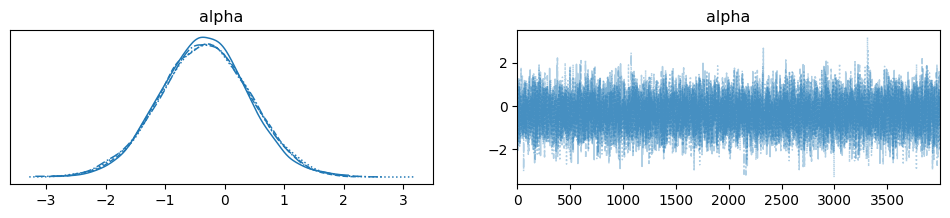

In [13]:
az.plot_trace(boxh1_trace, var_names=["alpha"])

In [15]:
alpha_summary = az.summary(boxh1_trace, var_names=["alpha"])
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[difficulty],-0.286,0.779,-1.743,1.160,0.006,0.006,16659.0,11693.0,1.0
alpha[trial],-0.139,0.716,-1.474,1.245,0.005,0.006,17931.0,11540.0,1.0


## H2. A game's difficulty configuration and trial have an effect on a player's perception of Mastery



In [16]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats, "vars": ["difficulty", "trial"]}) as mboxh2:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, dims="vars")
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)
    boxh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    # boxh2_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    

Sampling: [alpha, cutpoints, delta_0, delta_1, sigma, y]


<Axes: xlabel='y'>

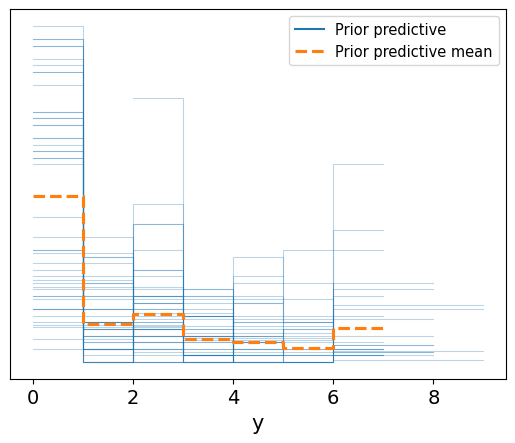

In [17]:
az.plot_ppc(
    boxh2_trace,
    data_pairs={"S": "S"},
    kind="kde",
    alpha=0.3,
    group="prior"
)

In [18]:
with mboxh2:
    boxh2_trace.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

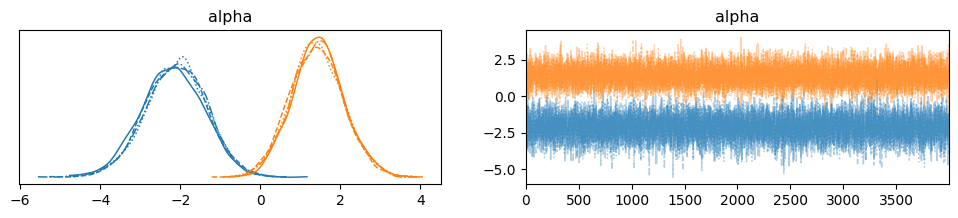

In [19]:
az.plot_trace(boxh2_trace, var_names=["alpha"])

In [20]:
az.summary(boxh2_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[difficulty],-2.139,0.775,-3.595,-0.698,0.008,0.006,9588.0,10013.0,1.0
alpha[trial],1.426,0.658,0.183,2.684,0.005,0.004,15606.0,11859.0,1.0


In [21]:
with mboxh2:
    pm.sample_posterior_predictive(boxh2_trace, extend_inferencedata=True, random_seed=rng)

Sampling: [y]


Output()

<Axes: xlabel='y'>

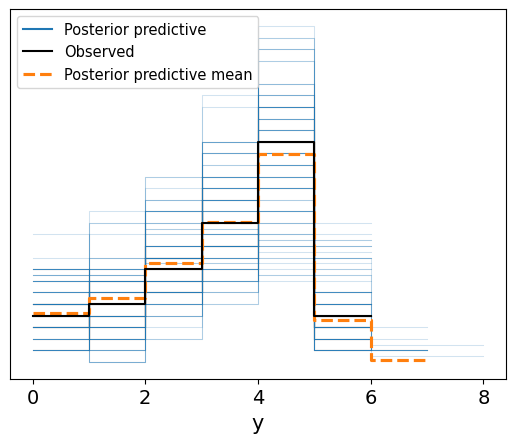

In [22]:
az.plot_ppc(
    boxh2_trace,
    num_pp_samples=100
)

## H3. A game's difficulty configuration and trial has an effect on its perception of Challenge

In [23]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats, "vars": ["difficulty", "trial"]}) as mboxh3:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, dims="vars")
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=ch_codes)
    boxh3_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    # boxh2_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")

Sampling: [alpha, cutpoints, delta_0, delta_1, sigma, y]


<Axes: xlabel='y'>

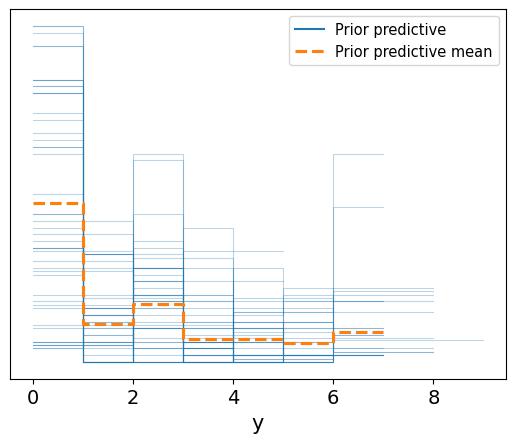

In [24]:
az.plot_ppc(
    boxh3_trace,
    data_pairs={"S": "S"},
    kind="kde",
    alpha=0.3,
    group="prior"
)

In [25]:
with mboxh3:
    boxh3_trace.extend(pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro"))

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

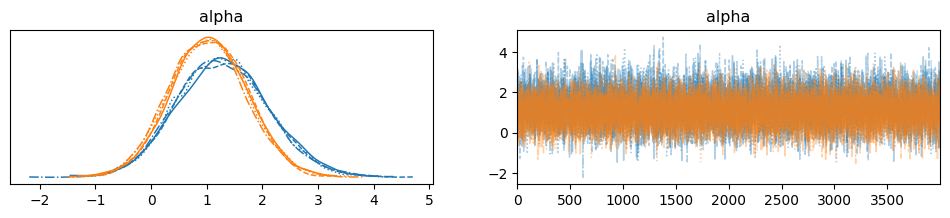

In [26]:
az.plot_trace(boxh3_trace, var_names=["alpha"])

In [27]:
az.summary(boxh3_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[difficulty],1.283,0.822,-0.242,2.832,0.008,0.006,10414.0,9816.0,1.0
alpha[trial],1.031,0.692,-0.255,2.340,0.006,0.004,13403.0,12580.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

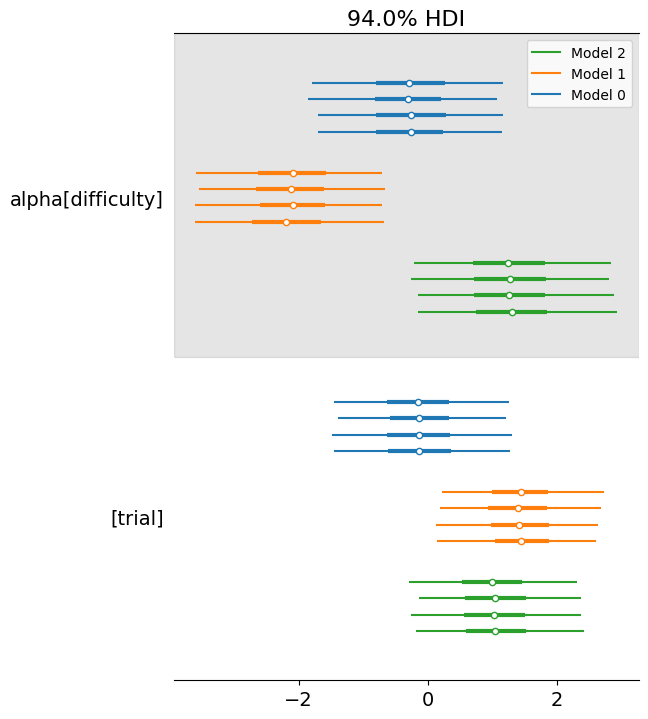

In [28]:
az.plot_forest([boxh1_trace, boxh2_trace, boxh3_trace],var_names="alpha")

## H4. A game's difficulty configuration and trial have an effect on their Performance



In [29]:
with pm.Model(coords={"trials": trial_cats, "difficulties": diff_cats}) as mboxh4:
    T = pm.Data("trial", trial_id)
    D = pm.Data("difficulty", diff_id)
    alpha = pm.Normal("alpha", 0,2, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    # phi = pm.HalfNormal('phi', 5)
    
    lambd = pm.Deterministic("lambd", pm.math.exp(alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T]))
    
    S = pm.Poisson("S", mu=lambd, observed=scores)

    boxh4_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

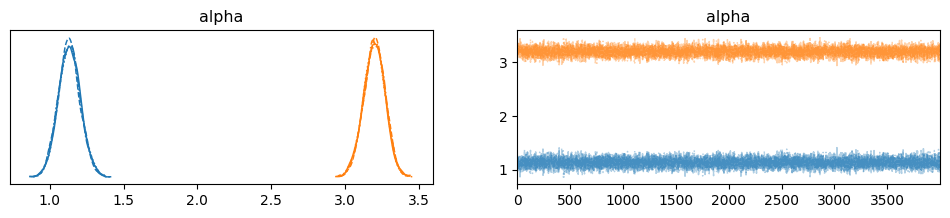

In [30]:
az.plot_trace(boxh4_trace,var_names=["alpha"])

In [31]:
az.summary(np.exp(boxh4_trace.posterior),var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],3.112,0.233,2.699,3.576,0.003,0.002,8130.0,9376.0,1.0
alpha[1],24.564,1.782,21.279,27.959,0.020,0.014,8107.0,9363.0,1.0


## H5: The effects of the trial and difficulty configuration on its perception of mastery are mediated by the score

In [32]:
scores_st = (scores - scores.mean())/scores.std()

In [33]:
with pm.Model(coords={"trials": trial_cats, "difficulties": diff_cats}) as m_boxh5:
    T = pm.Data("trial", trial_id)
    D = pm.Data("difficulty", diff_id)
    S = pm.Data("S", scores_st)
    MAS = pm.Data("MAS", mas_codes)
    
    alpha = pm.Normal("alpha", 0, 2, shape=2)
    beta = pm.Normal("beta",0, 2)
    
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T] + beta*S)
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=MAS)
    
    
    
    boxh5_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.95, random_seed=rng, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

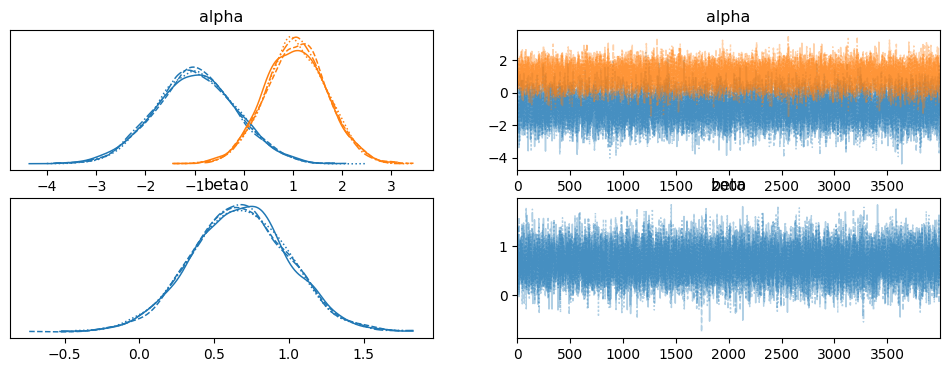

In [34]:
az.plot_trace(boxh5_trace, var_names=["alpha", "beta"])

In [35]:
az.summary(boxh5_trace, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.988,0.831,-2.470,0.647,0.008,0.006,10788.0,10902.0,1.0
alpha[1],1.064,0.629,-0.126,2.241,0.005,0.004,15462.0,12042.0,1.0
beta,0.672,0.328,0.052,1.282,0.003,0.002,14973.0,11845.0,1.0


# Turmoil

In [37]:
pxi_df_turm = pxi_df[pxi_df["game_name"] == "Turmoil"].drop(columns="game_name")
final_frames = logs_df[logs_df["game_name"]=="Turmoil-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_turm_df = logs_df.iloc[list(final_frames.values)]

turm_score = grouped_turm_df[["participant_id", "trial", "ram_9", "ram_10", "ram_57"]]
turm_final = pd.merge(pxi_df_turm, turm_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial")).dropna()
turm_final.shape


(54, 20)

In [38]:
def bcd16_to_decimal(hi_byte: int, lo_byte: int) -> int:
    """
    Convert a 16-bit BCD score (two bytes) to a regular integer.
    
    Parameters:
        hi_byte (int): High BCD byte (tens and thousands).
        lo_byte (int): Low BCD byte (ones and hundreds).
    
    Returns:
        int: The decoded decimal score.
    """
    # Extract nibbles from high byte
    hi_tens = (hi_byte >> 4) & 0x0F
    hi_ones = hi_byte & 0x0F
    
    # Extract nibbles from low byte
    lo_tens = (lo_byte >> 4) & 0x0F
    lo_ones = lo_byte & 0x0F
    
    # Compute decimal value
    return hi_tens * 1000 + hi_ones * 100 + lo_tens * 10 + lo_ones

turm_final["score"] = turm_final.apply(lambda x: bcd16_to_decimal(x['ram_10'], x['ram_9']), 
                        axis=1)
turm_final["deaths"] = 4 - turm_final["ram_57"]

In [141]:
def score_death_ratio(score, deaths):
    return score/(deaths + 1)

turm_final["score_death_ratio"] = turm_final.apply(lambda x: score_death_ratio(x['score'], x['deaths']), 
                        axis=1)

/tmp/ipykernel_10566/2466564796.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  a = sns.boxplot(x=turm_final["mode"], y=turm_final[variable[i]].str.lower().replace(pxi_id_to_number), ax=ax[i])
/tmp/ipykernel_10566/2466564796.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(range(-4,4,1), fontsize=12)
/tmp/ipykernel_10566/2466564796.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  a = sns.boxplot(x=turm_final["mode"], y=

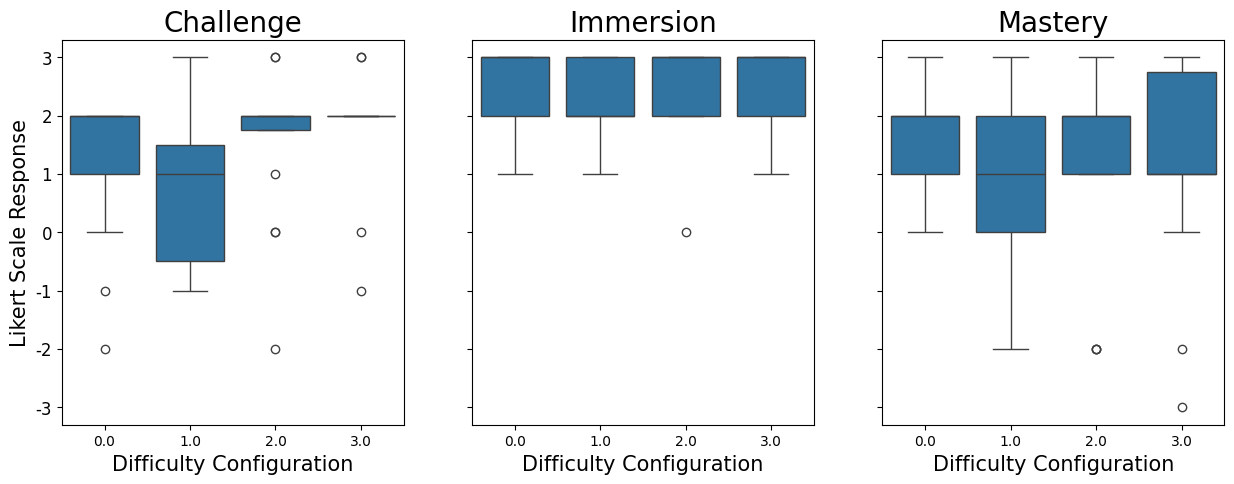

In [142]:
fig, ax = plt.subplots(1,3, figsize=(15,5),sharey=True, sharex=True)

variable = ["pxi_CH", "pxi_IMM", "pxi_MAS"]

label = ["Challenge", "Immersion", "Mastery"]

for i in range(3):
    a = sns.boxplot(x=turm_final["mode"], y=turm_final[variable[i]].str.lower().replace(pxi_id_to_number), ax=ax[i])
    a.set_title(label[i], fontsize=20)
    a.set_yticklabels(range(-4,4,1), fontsize=12)
    a.set_ylabel("Likert Scale Response", fontsize=15)
    a.set_xlabel("Difficulty Configuration", fontsize=15)
    
    # b = sns.boxplot(x=box_final["trial"], y=box_final[variable[i]].str.lower().replace(pxi_id_to_number), ax=ax[1,i])
    # b.set_title(label[i], fontsize=20)
    # b.set_yticklabels(range(-4,4,1), fontsize=12)
    # b.set_ylabel("Likert Scale Response", fontsize=15)
    # b.set_xlabel("Trial", fontsize=15)

/tmp/ipykernel_10566/3125354153.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=12)
/tmp/ipykernel_10566/3125354153.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_yticklabels(b.get_yticklabels(), fontsize=12)


Text(0.5, 0, 'Score')

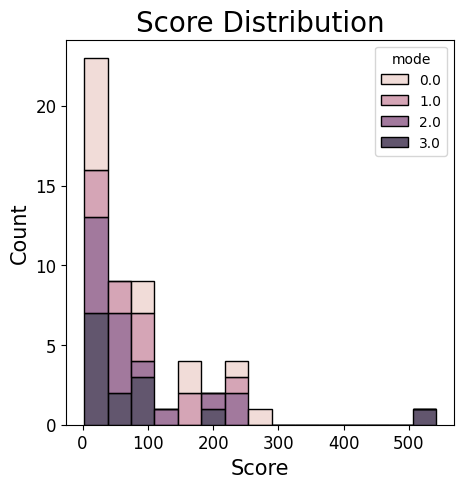

In [143]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
b = sns.histplot(x=turm_final["score_death_ratio"], hue=turm_final["mode"],ax=ax, multiple="stack",common_norm=False)
b.set_title("Score Distribution", fontsize=20)
b.set_xticklabels(b.get_xticklabels(), fontsize=12)
b.set_yticklabels(b.get_yticklabels(), fontsize=12)
b.set_ylabel("Count", fontsize=15)
b.set_xlabel("Score", fontsize=15)

In [144]:
pxi_id_to_number = {
    "strongly disagree": 0,
    "disagree": 1,
    "slightly disagree":2,
    "neutral": 3,
    "slightly agree": 4,
    "agree": 5,
    "strongly agree": 6
}

diff_id,   diff_cats = pd.factorize(turm_final["mode"], sort=True)
trial_id, trial_cats = pd.factorize(turm_final["trial"], sort=True)
ch_codes, ch_levels   = pd.factorize(turm_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
mas_codes, mas_levels   = pd.factorize(turm_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
imm_codes, imm_levels   = pd.factorize(turm_final["pxi_IMM"].str.lower().replace(pxi_id_to_number), sort=True)
scores                = turm_final["score_death_ratio"].values

/tmp/ipykernel_10566/674483900.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ch_codes, ch_levels   = pd.factorize(turm_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_10566/674483900.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mas_codes, mas_levels   = pd.factorize(turm_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_10566/674483900.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To reta

In [145]:
imm_levels

Index([3, 4, 5, 6], dtype='int64')

## H1: A game's difficulty configuration and trial has an effect on a player's perception of Immersion

In [146]:
with pm.Model(coords={"difficulties": diff_cats, "trials":trial_cats}) as mturmh1:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,3,3), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)
    
    
    turmh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True},target_accept=0.95, random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

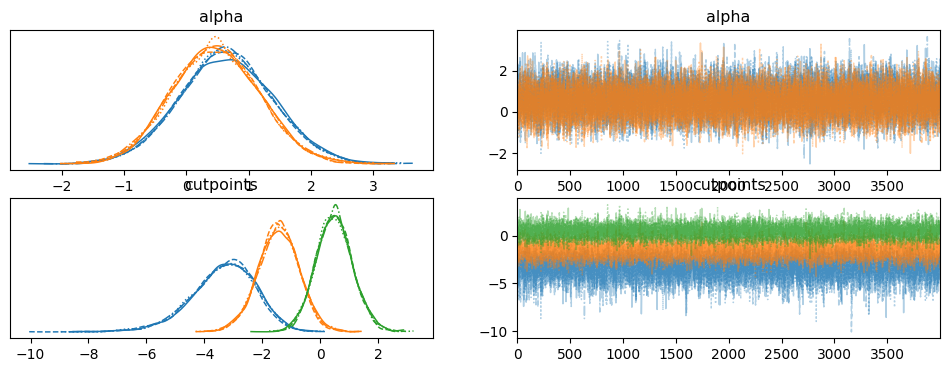

In [147]:
az.plot_trace(turmh1_trace, var_names=["alpha", "cutpoints"])

In [148]:
alpha_summary = az.summary(turmh1_trace, var_names="alpha")
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.641,0.747,-0.748,2.076,0.007,0.005,12675.0,10975.0,1.0
alpha[1],0.470,0.698,-0.832,1.767,0.007,0.005,11295.0,10548.0,1.0


## H2: A game's difficulty configuration and trial have an effect on their perception of mastery

In [149]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats}) as mturmh2:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)
    # turmh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    turmh2_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

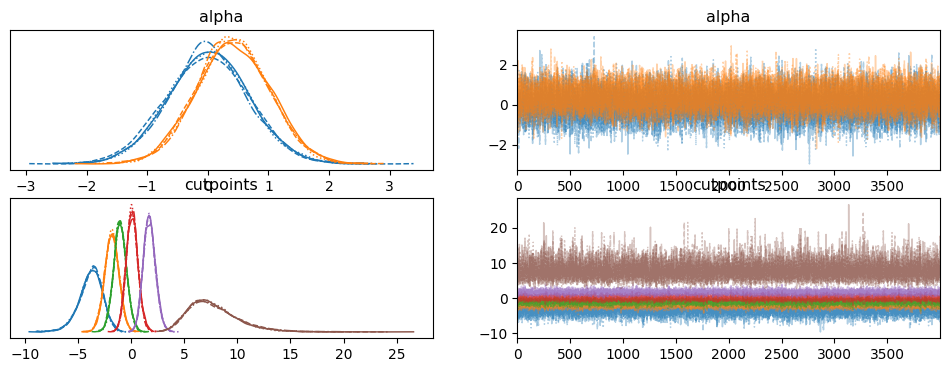

In [150]:
az.plot_trace(turmh2_trace,var_names=["alpha", "cutpoints"])

In [151]:
az.summary(turmh2_trace,var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.008,0.671,-1.190,1.342,0.006,0.005,13690.0,11649.0,1.0
alpha[1],0.414,0.601,-0.717,1.527,0.005,0.004,14669.0,11652.0,1.0


## H3 a game's Difficulty configuration and trial have an effect on the perception of challenge

In [152]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats}) as mturmh3:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=ch_codes)
    # turmh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    turmh3_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

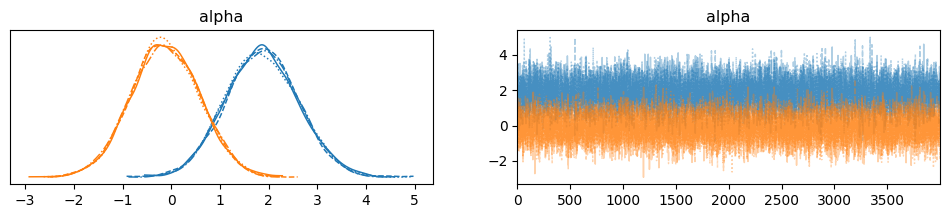

In [153]:
az.plot_trace(turmh3_trace, var_names="alpha")

In [154]:
az.summary(turmh3_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.865,0.743,0.514,3.294,0.007,0.005,11231.0,12266.0,1.0
alpha[1],-0.121,0.699,-1.361,1.255,0.007,0.005,9927.0,10805.0,1.0


## H4. A game's difficulty configuration and trial have an effect on their Performance

In [155]:
with pm.Model(coords={"trials": trial_cats, "difficulties": diff_cats}) as mturmh4:
    T = pm.Data("trial", trial_id)
    D = pm.Data("difficulty", diff_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    # phi = pm.HalfNormal('phi', 5)
    
    lambd = pm.Deterministic("lambd", pm.math.exp(alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T]))
    
    S = pm.Poisson("S", mu=lambd, observed=scores)

    turmh4_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

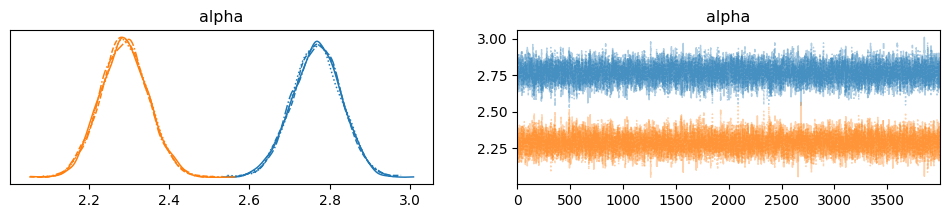

In [156]:
az.plot_trace(turmh4_trace, var_names="alpha")

In [157]:
az.summary(np.exp(turmh4_trace.posterior), var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],15.947,0.976,14.100,17.745,0.012,0.008,6833.0,8641.0,1.0
alpha[1],9.878,0.590,8.775,10.988,0.007,0.005,6933.0,8786.0,1.0


## H5: The effects of the trial and difficulty configuration on its perception of challenge are mediated by the score

In [158]:
scores_st = (scores - scores.mean())/scores.std()

In [159]:
with pm.Model(coords={"trials": trial_cats, "difficulties": diff_cats}) as m_turmh5:
    T = pm.Data("trial", trial_id)
    D = pm.Data("difficulty", diff_id)
    S = pm.Data("S", scores_st)
    CH = pm.Data("challenge", ch_codes)
    
    alpha = pm.Normal("alpha", 0, 2, shape=2)
    beta = pm.Normal("beta",0, 2)
    
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T] + beta*S)
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=CH)
    
    
    
    turmh5_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.95, random_seed=rng, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

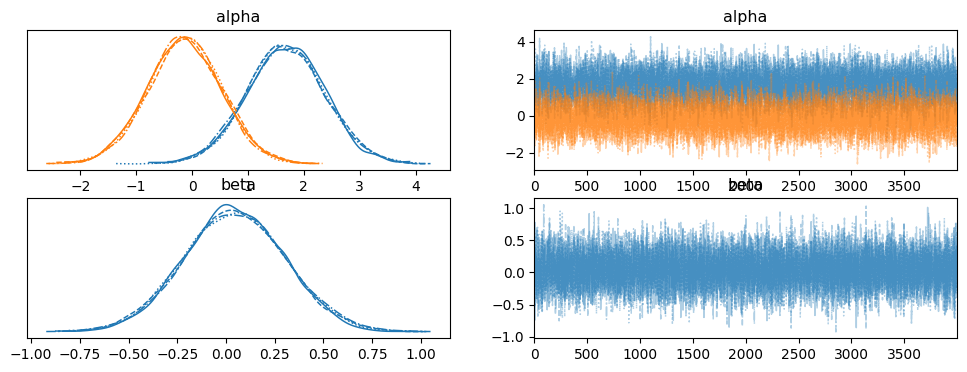

In [160]:
az.plot_trace(turmh5_trace, var_names=["alpha", "beta"])

In [161]:
az.summary(turmh5_trace, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.679,0.698,0.316,2.951,0.006,0.004,12970.0,12072.0,1.0
alpha[1],-0.138,0.659,-1.368,1.127,0.006,0.005,12096.0,12010.0,1.0
beta,0.044,0.260,-0.439,0.540,0.002,0.002,17616.0,11149.0,1.0


# Word Zapper

In [94]:
pxi_df_word = pxi_df[pxi_df["game_name"] == "WordZapper"].drop(columns="game_name")
final_frames = logs_df[logs_df["game_name"]=="WordZapper-v5"].groupby(["participant_id", "trial"])["frame"].idxmax()
grouped_word_df = logs_df.iloc[list(final_frames.values)]

word_score = grouped_word_df[["participant_id", "trial", "ram_98"]]
word_final = pd.merge(pxi_df_word, word_score, left_on=("participant_id", "trial"), right_on=("participant_id", "trial")).dropna()
word_final["ram_98"] = word_final["ram_98"].replace(2,0)


In [101]:
word_final.shape

(54, 18)

In [102]:
diff_id,   diff_cats = pd.factorize(word_final["mode"], sort=True)
trial_id,   trial_cats = pd.factorize(word_final["trial"], sort=True)
ch_codes, ch_levels   = pd.factorize(word_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
mas_codes, mas_levels   = pd.factorize(word_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
imm_codes, imm_levels   = pd.factorize(word_final["pxi_IMM"].str.lower().replace(pxi_id_to_number), sort=True)
gr_codes, gr_levels   = pd.factorize(word_final["pxi_GR"].str.lower().replace(pxi_id_to_number), sort=True)
scores                = word_final["ram_98"].values

/tmp/ipykernel_10566/3477249647.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ch_codes, ch_levels   = pd.factorize(word_final["pxi_CH"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_10566/3477249647.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mas_codes, mas_levels   = pd.factorize(word_final["pxi_MAS"].str.lower().replace(pxi_id_to_number), sort=True)
/tmp/ipykernel_10566/3477249647.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To reta

/tmp/ipykernel_10566/2728640322.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  a = sns.boxplot(x=word_final["mode"], y=word_final[variable[i]].str.lower().replace(pxi_id_to_number), ax=ax[i])
/tmp/ipykernel_10566/2728640322.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_yticklabels(range(-4,4,1), fontsize=12)
/tmp/ipykernel_10566/2728640322.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  a = sns.boxplot(x=word_final["mode"], y=

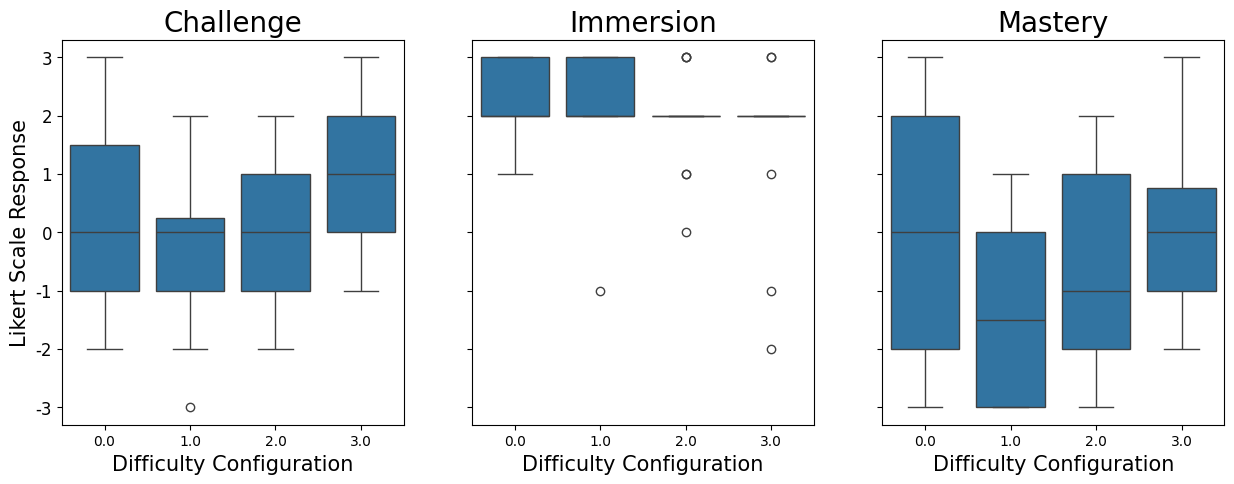

In [103]:
fig, ax = plt.subplots(1,3, figsize=(15,5),sharey=True, sharex=True)

variable = ["pxi_CH", "pxi_IMM", "pxi_MAS"]

label = ["Challenge", "Immersion", "Mastery"]

for i in range(3):
    a = sns.boxplot(x=word_final["mode"], y=word_final[variable[i]].str.lower().replace(pxi_id_to_number), ax=ax[i])
    a.set_title(label[i], fontsize=20)
    a.set_yticklabels(range(-4,4,1), fontsize=12)
    a.set_ylabel("Likert Scale Response", fontsize=15)
    a.set_xlabel("Difficulty Configuration", fontsize=15)
    
    # b = sns.boxplot(x=box_final["trial"], y=box_final[variable[i]].str.lower().replace(pxi_id_to_number), ax=ax[1,i])
    # b.set_title(label[i], fontsize=20)
    # b.set_yticklabels(range(-4,4,1), fontsize=12)
    # b.set_ylabel("Likert Scale Response", fontsize=15)
    # b.set_xlabel("Trial", fontsize=15)

In [104]:
scores

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0])

/tmp/ipykernel_10566/1253090790.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=12)
/tmp/ipykernel_10566/1253090790.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_yticklabels(b.get_yticklabels(), fontsize=12)


Text(0.5, 0, 'Score')

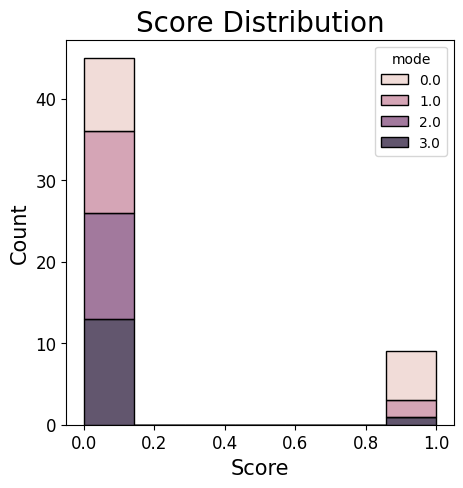

In [105]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
b = sns.histplot(x=word_final["ram_98"], hue=word_final["mode"],ax=ax, multiple="stack",common_norm=False)
b.set_title("Score Distribution", fontsize=20)
b.set_xticklabels(b.get_xticklabels(), fontsize=12)
b.set_yticklabels(b.get_yticklabels(), fontsize=12)
b.set_ylabel("Count", fontsize=15)
b.set_xlabel("Score", fontsize=15)

## H1: A game's difficulty configuration or current trial have an effect on on a player's perception of immersion

In [106]:
with pm.Model(coords={"difficulties": diff_cats, "trials":trial_cats}) as mwordh1:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,5,5), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=imm_codes)
    
    
    wordh1_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True},target_accept=0.95, random_seed=rng, nuts_sampler="numpyro")

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

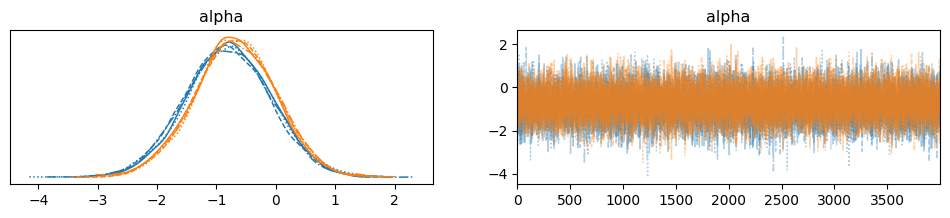

In [107]:
az.plot_trace(wordh1_trace, var_names="alpha")

In [108]:
az.summary(wordh1_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.802,0.727,-2.158,0.561,0.006,0.005,15407.0,11769.0,1.0
alpha[1],-0.684,0.687,-2.012,0.570,0.006,0.005,13921.0,11510.0,1.0


## H2: A game's difficulty configuration and trial have an effect on their perception of mastery

In [109]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats}) as mwordh2:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,0.5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=mas_codes)
    # turmh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    wordh2_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.97, random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'cutpoints'}>,
        <Axes: title={'center': 'cutpoints'}>]], dtype=object)

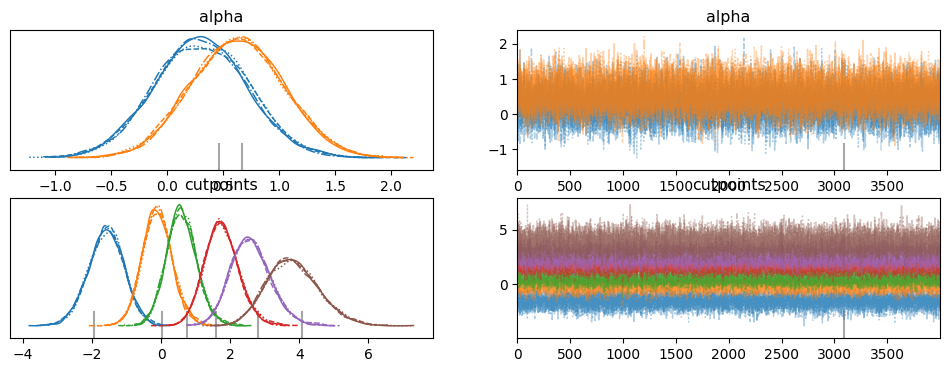

In [110]:
az.plot_trace(wordh2_trace,var_names=["alpha", "cutpoints"])

In [112]:
az.summary(wordh2_trace,var_names=["alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.303,0.418,-0.482,1.086,0.004,0.003,13288.0,11484.0,1.0
alpha[1],0.628,0.411,-0.153,1.380,0.003,0.003,13916.0,11366.0,1.0


## H3 a game's Difficulty configuration and trial have an effect on the perception of challenge

In [113]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats}) as mwordh3:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,2, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=ch_codes)
    # turmh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    wordh3_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.95,random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

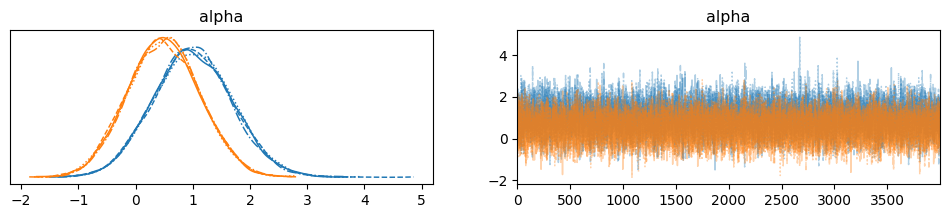

In [114]:
az.plot_trace(wordh3_trace, var_names="alpha")

In [115]:
az.summary(wordh3_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.000,0.688,-0.270,2.295,0.006,0.005,15760.0,11016.0,1.0
alpha[1],0.498,0.625,-0.664,1.671,0.004,0.004,19921.0,11939.0,1.0


## H4 a game's Difficulty configuration and trial have an effect on the perception of Goal Clarity

In [134]:
with pm.Model(coords={"difficulties": diff_cats, "trials": trial_cats}) as mwordh4:
    D = pm.Data("difficulty", diff_id)
    T = pm.Data("trial", trial_id)
    alpha = pm.Normal("alpha", 0,5, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    
    sigma = pm.Exponential("sigma", 1)
    
    eta = pm.Deterministic("eta", alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T])
    
    cutpoints = pm.Normal("cutpoints", mu=np.linspace(0,6,6), sigma=sigma,
                          transform=pm.distributions.transforms.ordered)
    
    y = pm.OrderedLogistic("y", eta=eta, cutpoints=cutpoints, observed=gr_codes)
    # turmh2_trace = pm.sample_prior_predictive(draws=50, random_seed=rng)
    wordh4_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, target_accept=0.95,random_seed=rng, nuts_sampler="numpyro")
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

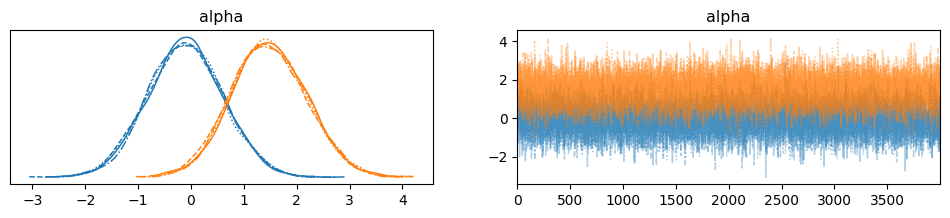

In [135]:
az.plot_trace(wordh4_trace, var_names="alpha")

In [136]:
az.summary(wordh4_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.110,0.710,-1.403,1.261,0.007,0.005,11679.0,12285.0,1.0
alpha[1],1.479,0.706,0.185,2.831,0.006,0.005,12687.0,11423.0,1.0


## H5. A game's difficulty configuration and trial have an effect on their Performance

In [138]:
with pm.Model(coords={"trials": trial_cats, "difficulties": diff_cats}) as mwordh5:
    T = pm.Data("trial", trial_id)
    D = pm.Data("difficulty", diff_id)
    alpha = pm.Normal("alpha", 0,1, shape=2)
    delta_0 = pm.Dirichlet("delta_0", np.ones(len(diff_cats)-1)*5)
    pad_0 = pm.math.concatenate([[0.0], delta_0])
    cum_delta_0 = pm.Deterministic("cum_delta_0", pad_0.cumsum(), dims="difficulties")

    delta_1 = pm.Dirichlet("delta_1", np.ones(len(trial_cats)-1)*5)
    pad_1 = pm.math.concatenate([[0.0], delta_1])
    cum_delta_1 = pm.Deterministic("cum_delta_1", pad_1.cumsum(), dims="trials")
    # phi = pm.HalfNormal('phi', 5)
    
    p = pm.Deterministic("p", pm.math.sigmoid(alpha[0]*cum_delta_0[D] + alpha[1]*cum_delta_1[T]))
    
    S = pm.Bernoulli("S", p=p, observed=scores)

    wordh5_trace = pm.sample(4000, tune=2000, idata_kwargs={"log_likelihood": True}, random_seed=rng, nuts_sampler="numpyro")
    
    

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/home/thejarmanitor/Documents/Scripts/ITU/thesis/.venv/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py:1153: UserWarning: Some donated buffers were not usable: ShapedArray(float64[4,4000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

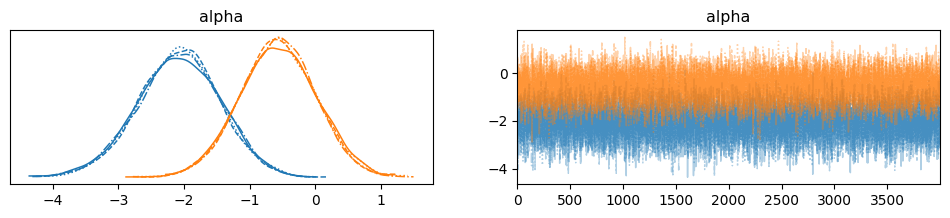

In [139]:
az.plot_trace(wordh5_trace, var_names="alpha")

In [140]:
az.summary(wordh5_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-2.083,0.626,-3.253,-0.885,0.005,0.004,15194.0,12451.0,1.0
alpha[1],-0.566,0.576,-1.642,0.526,0.005,0.004,14456.0,12611.0,1.0
